In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#For random forest for time series:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

#For metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import RFE

#For multiprocessing further down
import multiprocessing

#For timing stuff
import time

In [2]:
num_cores = multiprocessing.cpu_count()
print(num_cores)

num_cores = 4

8


In [3]:
def loadSeries(datatype=None,house=None,rename=None, shifts=None):
    '''
    Loading data series from cf_filled (consumption) or pf_filled (production)
    
    datatype: str, specifies whether the production or consumption values are selected
              
              "Production", "Consumption", "P", "C", "prod", "cons", etc.
    
    
    house: str, specifies which house is selected 
           
           "k28", "h16", "h22", "h28", or "h32"
         
    rename: str, renames chosen column. 
            
            If the whole file is returned, this parameter is ignored
            
    shifts: list of int, if given, specifies what shifted columns to add
    '''
    res = None
    #Production or consumption string stuff
    datatypeStr = ""
    if datatype is None:
        raise Exception("First input must specify either Production or Consumption")
    elif datatype[0].lower()=="p":
        datatypeStr = "prod_"
    elif datatype[0].lower()=="c":
        datatypeStr = "cons_"
    
    #Making sure an existing house is chosen
    if house is None:
        raise Exception("Second input must specify house: k28, h16, h22, h28, or h32")
    elif house.lower() not in ["k28","h16","h22","h28","h32"]:
        raise Exception("Second input must specify house: k28, h16, h22, h28, or h32")
    
    #Production or consumption is chosen and loaded
    if datatypeStr=="prod_":
        res = pd.read_csv("pf_filled.csv",sep=",")
        res = res[["Time",datatypeStr+house]]
        res["Time"] = pd.to_datetime(res["Time"], utc=True)
        res = res.set_index("Time").sort_index()
        res.index = pd.date_range(start=res.index[0], end=res.index[-1], freq="h")
    else:
        res = pd.read_csv("cf_filled.csv",sep=",")
        res["Time"] = pd.to_datetime(res["Time"], utc=True)
        res = res.set_index("Time").sort_index()
        res.index = pd.date_range(start=res.index[0], end=res.index[-1], freq="h")
    
    #Renaming value column
    if not house is None and not rename is None:
        res = res.rename(columns={datatypeStr+house: rename}, errors="raise")
    
    #Shifted columns added
    if not shifts is None:
        if rename is None:
            shiftname = 't'
        else:
            shiftname = rename
        dataframe = pd.DataFrame()
        for i in shifts:
           dataframe[shiftname + '-' + str(i)] = res.shift(i)
        res = pd.concat([res, dataframe], axis=1)
        res.dropna(inplace=True)
    
    #Nice stuff for indexing
    res['Year']=res.index.year
    res['Month']=res.index.month
    res['Day']=res.index.day
    res['Weekday']=res.index.weekday
    res['Hour']=res.index.hour
    return res

def moving_average(timeseries, window):
    return timeseries.rolling(window=window, center=True).mean()

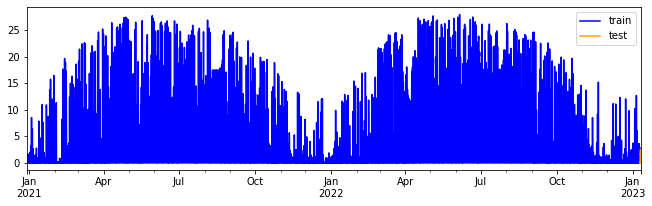

,val,val-24,val-48,val-168,Year,Month,Day,Weekday,Hour
2020-12-29 00:00:00+00:00,0.0,0.0,0.0,0.0,2020,12,29,1,0
2020-12-29 01:00:00+00:00,0.0,0.0,0.0,0.0,2020,12,29,1,1
2020-12-29 02:00:00+00:00,0.0,0.0,0.0,0.0,2020,12,29,1,2
2020-12-29 03:00:00+00:00,0.0,0.0,0.0,0.0,2020,12,29,1,3
2020-12-29 04:00:00+00:00,0.0,0.0,0.0,0.0,2020,12,29,1,4
...,...,...,...,...,...,...,...,...,...
2021-02-08 11:00:00+00:00,0.4,0.4,0.3,7.7,2021,2,8,0,11
2021-02-08 12:00:00+00:00,0.3,0.4,0.9,15.1,2021,2,8,0,12
2021-02-08 13:00:00+00:00,0.6,0.4,1.1,7.7,2021,2,8,0,13
2021-02-08 14:00:00+00:00,0.8,0.5,0.6,7.5,2021,2,8,0,14


In [4]:
train_series = loadSeries("p","h16","val", [24,48,168])
units_to_forecast = 24

train = train_series[:-units_to_forecast]
test = train_series[-units_to_forecast:]

fig, ax=plt.subplots(figsize=(11, 3))
moving_average(train['val'], 3).plot(ax=ax, label='train', color='blue')
moving_average(test['val'], 1).plot(ax=ax, label='test', color='orange')
ax.legend();
plt.show()
train_series.head(1000)

## Hyperparameter tuning

In [6]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 1 # This value will be replaced in the grid search
             )

# Lags used as predictors (defined above)
lags_grid = [1,5,10]
# Regressor's hyperparameters
param_grid = {'n_estimators': np.arange(start=100, stop=1000, step=100, dtype=int),
              'max_depth': np.arange(start=6, stop=10, step=1, dtype=int),
              'max_features': np.arange(start=3, stop=5, step=1, dtype=int),
              'n_jobs': [num_cores]}
start = time.time()
results_grid = grid_search_forecaster(
                            forecaster         = forecaster,
                            y                  = train_series[24*182-(2*7*24+24):24*182]['val'],
                            exog               = train_series[24*182-(2*7*24+24):24*182].drop(['val'], axis=1),
                            param_grid         = param_grid,
                            lags_grid          = lags_grid,
                            steps              = units_to_forecast,
                            refit              = True,
                            metric             = 'mean_squared_error',
                            initial_train_size = 2*7*24,
                            return_best        = True,
                            fixed_train_size   = True,
                            verbose            = False
                   )
end = time.time()
print("Searching took {}s".format(end-start))
results_grid

Number of models compared: 216.


loop param_grid:  33%|████████████                        | 24/72 [00:40<01:22,  1.71s/it]


loop lags_grid: 100%|██████████████████████████████████████| 3/3 [06:39<00:00, 133.28s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 8, 'max_features': 3, 'n_estimators': 100, 'n_jobs': 4}
  Backtesting metric: 79.02211104100202

Searching took 400.0389337539673s


,lags,params,mean_squared_error,max_depth,max_features,n_estimators,n_jobs
180,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 8, 'max_features': 3, 'n_estimat...",79.022111,8,3,100,4
183,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 8, 'max_features': 3, 'n_estimat...",79.750380,8,3,400,4
182,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 8, 'max_features': 3, 'n_estimat...",80.492599,8,3,300,4
185,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 8, 'max_features': 3, 'n_estimat...",80.950101,8,3,600,4
187,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 8, 'max_features': 3, 'n_estimat...",80.975157,8,3,800,4
...,...,...,...,...,...,...,...
10,[1],"{'max_depth': 6, 'max_features': 4, 'n_estimat...",111.726055,6,4,200,4
65,[1],"{'max_depth': 9, 'max_features': 4, 'n_estimat...",111.733522,9,4,300,4
29,[1],"{'max_depth': 7, 'max_features': 4, 'n_estimat...",113.397374,7,4,300,4
28,[1],"{'max_depth': 7, 'max_features': 4, 'n_estimat...",114.158936,7,4,200,4


In [20]:
start = time.time()
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = train_series[24*(365+13)-2*7*24:24*(365+13)+24*7]['val'],
                            exog       = train_series[24*(365+13)-2*7*24:24*(365+13)+24*7].drop(['val'], axis=1),
                            initial_train_size = 2*7*24,
                            steps      = units_to_forecast,
                            refit      = True,
                            interval   = [5/2, 100-5/2],
                            n_boot     = 500,
                            metric     = 'mean_squared_error',
                            fixed_train_size   = True,
                            verbose    = True
                        )
end = time.time()
print("Training took {}s".format(end-start))
predictions.head(4)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 336
Number of observations used for backtesting: 168
    Number of folds: 7
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2021-12-28 00:00:00+00:00 -- 2022-01-10 23:00:00+00:00  (n=336)
    Validation: 2022-01-11 00:00:00+00:00 -- 2022-01-11 23:00:00+00:00  (n=24)
Data partition in fold: 1
    Training:   2021-12-29 00:00:00+00:00 -- 2022-01-11 23:00:00+00:00  (n=336)
    Validation: 2022-01-12 00:00:00+00:00 -- 2022-01-12 23:00:00+00:00  (n=24)
Data partition in fold: 2
    Training:   2021-12-30 00:00:00+00:00 -- 2022-01-12 23:00:00+00:00  (n=336)
    Validation: 2022-01-13 00:00:00+00:00 -- 2022-01-13 23:00:00+00:00  (n=24)
Data partition in fold: 3
    Training:   2021-12-31 00:00:00+00:00 -- 2022-01-13 23:00:00+00:00  (n=336)
    Validation: 2022-01-14 00:00:00+00:00 -- 2022-01-14 23:00:00+00:00  (n=24)
Data partition in fold: 4
    

,pred,lower_bound,upper_bound
2022-01-11 00:00:00+00:00,0.013341,-0.507787,0.744103
2022-01-11 01:00:00+00:00,0.010734,-0.428972,0.888720
2022-01-11 02:00:00+00:00,0.007799,-0.457745,0.876717
2022-01-11 03:00:00+00:00,0.008191,-0.454130,0.886177


In [21]:
predictions.to_csv("predictions.csv")
results_grid.to_csv("results_grid.csv")
predictions =  pd.read_csv("predictions.csv")
results_grid = pd.read_csv("results_grid.csv")
predictions = predictions.rename(columns={"Unnamed: 0": "Time"}, errors="raise")

predictions = predictions[["Time","pred","lower_bound","upper_bound"]]
predictions["Time"] = pd.to_datetime(predictions["Time"], utc=True)
predictions = predictions.set_index("Time").sort_index()
predictions.index = pd.date_range(start=predictions.index[0], end=predictions.index[-1], freq="h")

predictions.head(4)

,pred,lower_bound,upper_bound
2022-01-11 00:00:00+00:00,0.013341,-0.507787,0.744103
2022-01-11 01:00:00+00:00,0.010734,-0.428972,0.888720
2022-01-11 02:00:00+00:00,0.007799,-0.457745,0.876717
2022-01-11 03:00:00+00:00,0.008191,-0.454130,0.886177


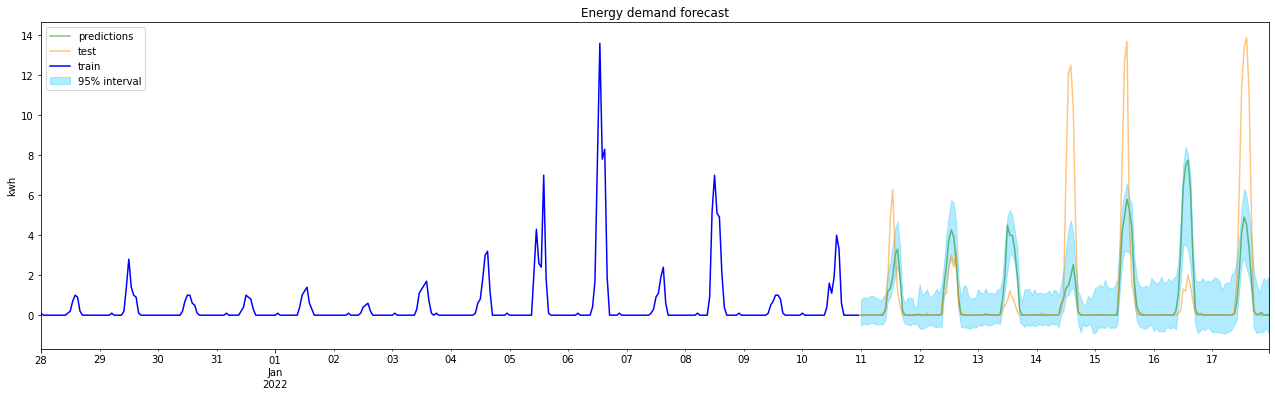

In [22]:
fig, ax=plt.subplots(figsize=(22, 6))
predictions['pred'].plot(ax=ax, label='predictions', color="green",alpha=0.5)
train_series[24*(365+13):24*(365+13)+24*7]['val'].plot(ax=ax, label='test', color="darkorange", alpha=0.5)
train_series[24*(365+13)-2*24*7:24*(365+13)]['val'].plot(ax=ax, label='train', color="blue")
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'deepskyblue',
    alpha = 0.3,
    label = '95% interval'
)
#ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel('kwh')
ax.set_title('Energy demand forecast')
ax.legend();

In [23]:
error_mse = mean_squared_error(
                y_true = train_series[24*(365+13):24*(365+13)+24*7]['val'],
                y_pred = predictions['pred']
            )

print(f"Test error (mse): {error_mse}")
print(f"Metric (mse): {metric}")

inside_interval = np.where(
                     (train_series.loc[predictions.index, 'val'] >= predictions['lower_bound']) & \
                     (train_series.loc[predictions.index, 'val'] <= predictions['upper_bound']),
                     True,
                     False
                  )

coverage = inside_interval.mean()
print(f"Coverage of the predicted interval on test data: {100 * coverage}%")

Test error (mse): 5.928280674528791
Metric (mse): 5.928280674528791
Coverage of the predicted interval on test data: 78.57142857142857%


In [24]:
naive_model = np.zeros((len(predictions)))

naive_mse = mean_squared_error(
                y_true = train_series[24*(365+13):24*(365+13)+24*7]['val'],
                y_pred = naive_model
            )
print(f"Test error (mse): {naive_mse}")

better = error_mse/naive_mse

print(f"How much fractionally less error that a naive model: {better*100}%")

Test error (mse): 10.30541666666428
How much fractionally less error that a naive model: 57.52587077537052%


In [25]:
naive_model2 = train_series[24*(365+13)-24*7:24*(365+13)]
naive_model2.index = train_series[24*(365+13):24*(365+13)+24*7].index

naive_mse2 = mean_squared_error(
                y_true = train_series[24*(365+13):24*(365+13)+24*7]['val'],
                y_pred = naive_model2['val']
            )
print(f"Test error (mse): {naive_mse2}")

better2 = error_mse/naive_mse2

print(f"How much fractionally less error that a naive model: {better2*100}%")

Test error (mse): 7.71708333332614
How much fractionally less error that a naive model: 76.82022363199806%
